***On-campus Landmarks Recognition System (OLRS)***

**This is the Model Training program for the OLRS**

In [12]:
import os
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torchvision.models as models
from sklearn.manifold import TSNE
import seaborn as sns
from time import time
import copy
from collections import Counter

In [13]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # if you are using Colab, ensure the `workspace` is set correctly
    workspace = '/content/drive/MyDrive/Colab Notebooks' 
except:
    workspace = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# ========== Define and implement all utility classes and functions ==========

In [15]:
samples = []
idx_label_desc = dict()
BATCH_SIZE = 2
IMG_SIZE = 128

In [16]:
class Sample:
    def __init__(self, idx=0, fname='', img=None, colorImg=None, feat=None, VGGfeat=None, label=None):
        self.idx = idx
        self.fname = fname
        self.img = img
        self.colorImg = colorImg
        self.feat = feat
        self.VGGfeat = VGGfeat
        self.label = label
        self.pred = None

def squareImg(image):
    img_h_saxis = image.shape[0]//2
    img_w_saxis = image.shape[1]//2
    crop_saxis = min((img_h_saxis, img_w_saxis))
    center = (img_h_saxis, img_w_saxis)
    cropped_img = image[(center[0]-crop_saxis): (center[0]+ crop_saxis),
                        (center[1]-crop_saxis): (center[1]+ crop_saxis)]
    return cropped_img

def loadLabelDescription():
    label_map_path = os.path.join(workspace, 'label-map.csv')
    if os.path.exists(label_map_path):
        with open(label_map_path) as f:
            csv_reader = csv.reader(f)
            counter = -1
            for line in csv_reader:
                if counter != -1:
                    idx_label_desc[counter]=line[1:]
                    print(idx_label_desc[counter])
                counter+=1

def loadImage():
    root = os.path.join(workspace, 'polyuPics')
    label_path = os.path.join(root, 'label.csv')
    if os.path.exists(label_path):
        with open(label_path) as f:
            flabels = list(csv.reader(f))
    else:
        raise ValueError('Invalid label file path [%s]'%label_path)

    for idx, fname, label in flabels[1:]:
        idx, label = int(idx), int(label)
        fpath = os.path.join(root, fname)
        if not os.path.isfile(fpath):
            raise ValueError('%s not found' % fpath)
        else:
            img = cv2.imread(fpath, cv2.IMREAD_COLOR) 
            colorImg = img[..., ::-1] #BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey scale
            
            colorImg = squareImg(colorImg)
            colorImg = cv2.resize(colorImg, (IMG_SIZE,IMG_SIZE))

            img = squareImg(img) # crop to square
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            feat = extractPixelFeature(img)
            samples.append(Sample(idx, fname, img, colorImg, feat, None, label))
    return samples

def img2Sample(inPath):
    root = os.path.join(workspace, 'polyuPics')
    fname = inPath
    imPath = os.path.join(root, fname)

    img = cv2.imread(imPath, cv2.IMREAD_COLOR) 
    colorImg = img[..., ::-1] #BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey scale

    colorImg = squareImg(colorImg)
    colorImg = cv2.resize(colorImg, (IMG_SIZE,IMG_SIZE))

    img = squareImg(img) # crop to square
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    feat = extractPixelFeature(img)
    return Sample(0, imPath, img, colorImg, feat, None, None)

def get_feat(img):
      return gray_histogram(img)

def gray_histogram(img: np.array, norm: bool = True) -> np.array:
    if img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = np.array([len(img[img == i]) for i in range(256)])
    if norm:
        return hist / np.size(img)
    return hist

def color_histogram(img : np.array, norm : bool = True) -> np.array:
    return np.concatenate([gray_histogram(img[..., i], norm=norm) for i in range(3)])

def extractPixelFeature(inImage):
    img_square = squareImg(inImage)
    img_cropped_50 = cv2.resize(img_square, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA) # resize to 28*28
    feat = img_cropped_50.reshape(1,-1)/255 # normalize by 255 to 0-1
    return feat[0]

def assignPixelFeatures():
    for sample in samples:
        sample.feat = extractPixelFeature(sample.img)


In [17]:
# ---------- class and function for 2 CNN model (2 ConvNet + 3 FC), (1 ConvNet + 2 FC) ----------

# define CNN model (2 ConvNet + 3 FC)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 128 * 128 * 1 => 128 * 128 * 32, 3x3 conv filter, padding 2
        self.conv1 = nn.Sequential(             # input shape (1, 128, 128)
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,           
                kernel_size=5,              
                stride=1,                   
                padding=2,                      # same width and length after con2d, padding=(kernel_size-1)/2
            ),                                  # output shape (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),        # choose max value in 2x2 area, output shape (32, 64, 64)
        )
        
        self.conv2 = nn.Sequential(             # input shape (32, 64, 64)
            nn.Conv2d(32, 64, 5, 1, 2),         # output shape (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),        # output shape (64, 32, 32)
        )
        
        self.d1 = nn.Linear(64 * 32 * 32, 256)  # fully connected layer
        self.d2 = nn.Linear(256, 128)           # fully connected layer
        self.d3 = nn.Linear(128, 15)            # fully connected layer, output 15 classes
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # flatten the output of conv2
        x = self.d1(x)
        x = F.relu(x)
        x = self.d2(x)
        x = F.relu(x)
        x = self.d3(x)
        output = self.sigmoid(x)

        return output

# define Simple CNN model (1 ConvNet + 2 FC)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # 128 * 128 * 1 => 128 * 128 * 32, 3x3 conv filter, padding 2
        self.conv1 = nn.Sequential(             # input shape (1, 128, 128)
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,           
                kernel_size=5,              
                stride=1,                   
                padding=2,                      # same width and length after con2d, padding=(kernel_size-1)/2
            ),                                  # output shape (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),        # choose max value in 2x2 area, output shape (32, 64, 64)
        )
        
        self.d1 = nn.Linear(32 * 64 * 64, 256)  # fully connected layer
        self.d2 = nn.Linear(256, 15)            # fully connected layer, output 15 classes
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1) # flatten the output of conv2
        x = self.d1(x)
        x = F.relu(x)
        x = self.d2(x)
        output = self.sigmoid(x)

        return output

def getCNNImgData(inImg):    
    normalize = transforms.Normalize(
        mean=[0.456],
        std=[0.224]
    )
    preprocess = transforms.Compose([
        transforms.Resize([IMG_SIZE,IMG_SIZE]),
        transforms.ToTensor(),
        normalize
    ])
    img_tensor = preprocess(Image.fromarray(inImg))
    return img_tensor

def loadCNNData(inTrain, inTest):
    
    normalize = transforms.Normalize(
        mean=[0.456],
        std=[0.224]
    )
    preprocess = transforms.Compose([
        transforms.Resize([IMG_SIZE,IMG_SIZE]),
        transforms.ToTensor(),
        normalize
    ])

    def default_loader(img):
        img_tensor = preprocess(Image.fromarray(img))
        return img_tensor

    class Trainset(Dataset):
        def __init__(self,loader=default_loader):
            self.samples = inTrain
            self.loader = loader

        def __getitem__(self, index):
            sample = self.samples[index]
            img = self.loader(sample.img)
            label = sample.label
            return img, label

        def __len__(self):
            return len(self.samples)
    trainset = Trainset(default_loader)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)
    
    class Testset(Dataset):
        def __init__(self,loader=default_loader):
            self.samples = inTest
            self.loader = loader

        def __getitem__(self, index):
            sample = self.samples[index]
            img = self.loader(sample.img)
            label = sample.label
            return img, label

        def __len__(self):
            return len(self.samples)

    testset = Testset(default_loader)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0)
    return trainloader, testloader


# compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def trainCNN(inModelType, inEpochs = 20, inLr = 0.0001):
    # trian CNN
    accuracyList = dict()
    lossList = dict()
    if inModelType == 0:
        model = CNN()
    else:
        model = SimpleCNN()
    for images, labels in trainloader:
        print("batch size:", images.shape)
        out = model(images)
        print(out.shape)
        break
    
    learning_rate = inLr
    num_epochs = inEpochs

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss() # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # updating the parameters

    for epoch in range(num_epochs): # iterrrre
        train_running_loss = 0.0
        train_acc = 0.0

        model = model.train()

        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        
        model.eval()
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_running_loss / i, train_acc/i)) 
        accuracyList[epoch]=train_acc/i
        lossList[epoch]=train_running_loss/i
    print(accuracyList)
    print(lossList)
    return model, accuracyList, lossList

def plotCNNAccLoss(inAcc, inLoss):
    plt.title("CNN Training Accuracy and Loss Plot")
    plt.plot(inAcc.keys(),inAcc.values(), label="Accuracy")
    plt.plot(inLoss.keys(),inLoss.values(), label="Loss")
    plt.legend()
    plt.show()

def predictCNN(inPath, inModel):
    imgSample = img2Sample(inPath)
    img = imgSample.img
    samData = getCNNImgData(img)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    samData = samData.view(1, 1, IMG_SIZE, IMG_SIZE)
    inModel.eval()
    pred = inModel(samData)
    prediction = int(torch.max(pred.data, 1)[1].numpy())
    return prediction

In [18]:
# ---------- class and function for VGG image retrival model----------

# load a pretrained DCNN
class VGGFeature(nn.Module):
    def __init__(self, pretrained=True, layer=28):
        super().__init__()
        self.net = models.vgg16(pretrained).features.eval()
        self.layer = layer
        self.requires_grad_(False)

    def forward(self, x):
        for idx, layer in enumerate(self.net):
            x = layer(x)
            if idx == self.layer:
                return x
def trainVGG():
    trainSet, testSet = train_test_split(samples, test_size = 0.3, train_size = 0.7,random_state = 10)
    print("Training Size:",len(trainSet),"Testing Size:",len(testSet))

    force_cpu = False

    if torch.cuda.is_available() and not force_cpu:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    print('We are using device', device)

    VGG = VGGFeature().to(device)

    for sample in samples:
        img = np.ascontiguousarray(sample.colorImg.transpose(2,0,1)) # HWC -> CHW
        img = torch.tensor(img, dtype=torch.float32, device=device)[None] # np.array -> torch.tensor & CHW -> NCHW
        feat = VGG(img)
        sample.VGGfeat = feat.max(dim=3)[0].max(dim=2)[0]
    
    return VGG

def testVGG():
    cos = nn.CosineSimilarity(dim=1)
    all_feats = torch.cat([sample.VGGfeat.view(1, -1) for sample in samples], dim=0)
    totalCount = 0
    correctCount = 0
    showCount = 0
    for idx, sample in enumerate(samples):
        totalCount += 1
        dists = cos(sample.VGGfeat.view(1, -1).expand_as(all_feats), all_feats)
        simlarity, orders = torch.sort(dists, descending=True)
        
        if (showCount<5):
            plt.figure(figsize=(18,4))
            plt.subplot(1, 5, 1)
            plt.title(f'query: {sample.fname}')
            plt.imshow(sample.img)
        
        count = 0
        for i, order in enumerate(orders[1:5]):
            
            result = samples[order]
            if (sample.label == result.label and count == 0):
                correctCount += 1
                count = 1
            if (showCount<5):
                plt.subplot(1, 5, i+2)
                plt.title(f'{result.fname} - %.3f' % simlarity[i+1])
                plt.imshow(result.img)
        showCount+=1
    print("VGG Model Total accuracy: ",correctCount/totalCount)

def predictVGG(inPath, VGG):
    target = img2Sample(inPath)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    img = np.ascontiguousarray(target.colorImg.transpose(2, 0, 1)) # HWC -> CHW
    img = torch.tensor(img, dtype=torch.float32, device=device)[None] # np.array -> torch.tensor & CHW -> NCHW
    feat = VGG(img)
    target.VGGfeat = feat.max(dim=3)[0].max(dim=2)[0]
    cos = nn.CosineSimilarity(dim=1)

    all_feats = torch.cat([sample.VGGfeat.view(1, -1) for sample in samples], dim=0)
    
    dists = cos(target.VGGfeat.view(1, -1).expand_as(all_feats), all_feats)
    simlarity, orders = torch.sort(dists, descending=True)
    
    for i, order in enumerate(orders[1:2]):
        result = samples[order]
        return result.label

In [19]:
# ========== End of define and implement all utility classes and functions ==========

# ========== Start load image dataset, preprocess image dataset, initialize dataloader, train and test models ==========

In [20]:
# load label index and description
loadLabelDescription()

# Load all images
samples = []
loadImage()
print("Sample Size:",len(samples))

# Split training set ans testing set
# The whole dataset is used as training set, and 30% of the training set is used as testing set
# This is a WRONG practice, we should not leak the testing data into the training set
_, testSet = train_test_split(samples, test_size = 0.3, train_size = 0.7,random_state = 10) # wrong practice
# Instead, we should split the whole dataset into training set and testing set, like:
# samples, testSet = train_test_split(samples, test_size = 0.3, train_size = 0.7,random_state = 10) # correct practice
print("Training Size:",len(samples),"Testing Size:",len(testSet))

['Communal Building', 'Communal Building']
['LibCafe', 'LibCafe']
['Li Ka Shing Tower', 'Li Ka Shing Tower']
['Jockey Club Innovation Tower', 'Jockey Club Innovation Tower']
['Lee Shau Kee Building', 'Lee Shau Kee Building']
['Block VA', 'Block VA']
['Logo Square', ' Logo Square']
['Jockey Club Auditorium', 'Jockey Club Auditorium']
['Global Student Hub', 'Global Student Hub']
['Industrial Centre', 'Industrial Centre']
['Pao Yue-Kong Library', 'Pao Yue-Kong Library']
['Main Entrance', 'Main Entrance']
['Block X Sport Center', 'Block X Sport Center']
['Lawn', 'Lawn']
Sample Size: 344
Training Size: 344 Testing Size: 104


<BarContainer object of 14 artists>

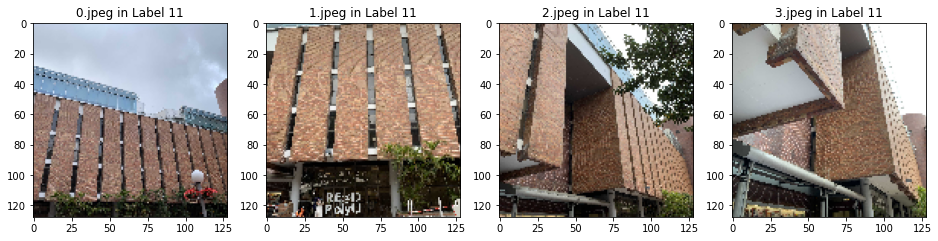

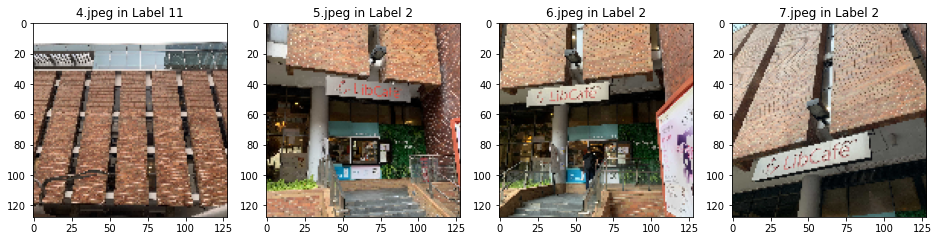

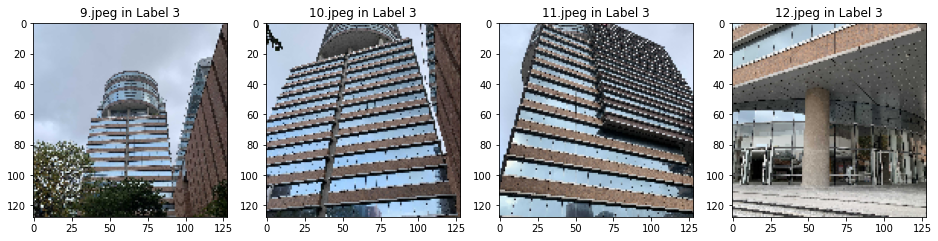

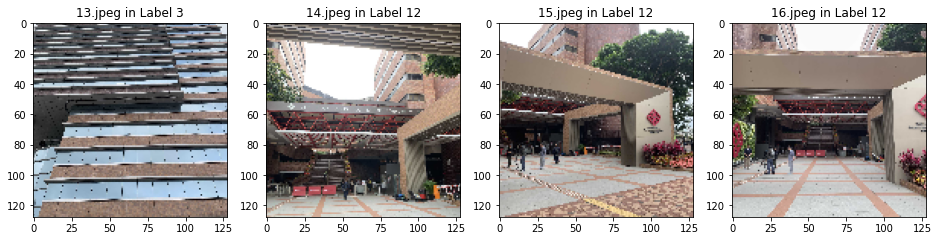

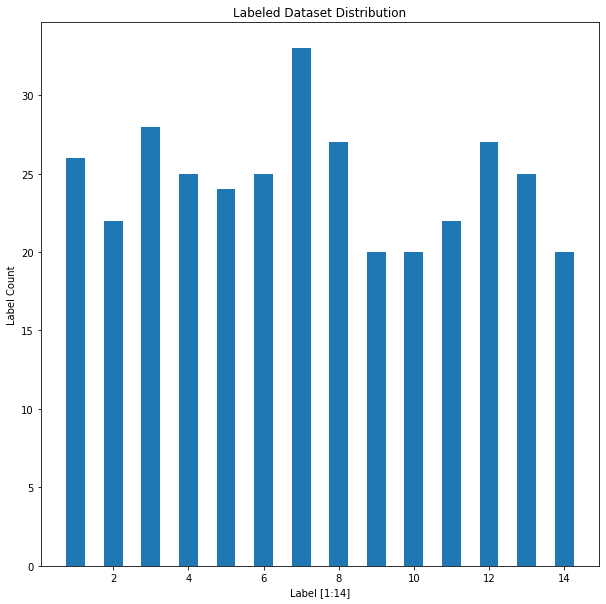

In [21]:
imgCount = 0
for sample in samples:
    idx = imgCount*10
    fname = sample.fname
    label = sample.label
    img = sample.colorImg
    idx, label = int(idx), int(label)
    if imgCount % 4 == 0:
        plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, imgCount%4+1)
    plt.title(f'{fname} in Label {label}')

    plt.imshow(img)
    imgCount+=1
    if (imgCount >= 16):
        break
        
labels = [sample.label for sample in samples]
keys = Counter(labels).keys()
counts = Counter(labels).values()
plt.figure(figsize=(10, 10))
plt.title("Labeled Dataset Distribution")
plt.xlabel("Label [1:14]")
plt.ylabel("Label Count")
plt.bar(Counter(labels).keys(),Counter(labels).values(),width=0.5)

In [22]:
# Load into trainLoader and testLoader
trainloader, testloader = loadCNNData(samples, testSet)
dataloader,dataloader = loadCNNData(samples,samples)
print("Training Loader Size:",len(trainloader),"Testing Loader Size:",len(testloader))

Training Loader Size: 172 Testing Loader Size: 52


batch size: torch.Size([2, 1, 128, 128])
torch.Size([2, 15])
Epoch: 0 | Loss: 2.6445 | Train Accuracy: 13.45
Epoch: 1 | Loss: 2.3575 | Train Accuracy: 27.78
Epoch: 2 | Loss: 2.2392 | Train Accuracy: 36.84
Epoch: 3 | Loss: 2.1339 | Train Accuracy: 52.92
Epoch: 4 | Loss: 2.0780 | Train Accuracy: 62.28
Epoch: 5 | Loss: 2.0394 | Train Accuracy: 68.71
Epoch: 6 | Loss: 1.9954 | Train Accuracy: 77.19
Epoch: 7 | Loss: 1.9597 | Train Accuracy: 80.99
Epoch: 8 | Loss: 1.9602 | Train Accuracy: 78.95
Epoch: 9 | Loss: 1.9264 | Train Accuracy: 83.92
Epoch: 10 | Loss: 1.9073 | Train Accuracy: 87.13
Epoch: 11 | Loss: 1.8958 | Train Accuracy: 89.18
Epoch: 12 | Loss: 1.8852 | Train Accuracy: 89.47
Epoch: 13 | Loss: 1.8759 | Train Accuracy: 89.18
Epoch: 14 | Loss: 1.8785 | Train Accuracy: 86.55
Epoch: 15 | Loss: 1.8668 | Train Accuracy: 91.23
Epoch: 16 | Loss: 1.8619 | Train Accuracy: 91.23
Epoch: 17 | Loss: 1.8606 | Train Accuracy: 92.98
Epoch: 18 | Loss: 1.8605 | Train Accuracy: 91.23
Epoch: 19 | Loss: 

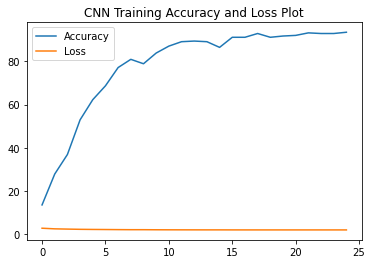

In [23]:
## CNN Model

# Train and save the model
modelCNN,accuracy,loss = trainCNN(0,25,0.0001)
torch.save(modelCNN, 'modelCNN.pth')
plotCNNAccLoss(accuracy, loss)

batch size: torch.Size([2, 1, 128, 128])
torch.Size([2, 15])
Epoch: 0 | Loss: 2.7853 | Train Accuracy: 9.94
Epoch: 1 | Loss: 2.7558 | Train Accuracy: 10.23
Epoch: 2 | Loss: 2.7339 | Train Accuracy: 12.28
Epoch: 3 | Loss: 2.6853 | Train Accuracy: 8.77
Epoch: 4 | Loss: 2.6335 | Train Accuracy: 8.48
Epoch: 5 | Loss: 2.6635 | Train Accuracy: 6.43
Epoch: 6 | Loss: 2.6260 | Train Accuracy: 7.60
Epoch: 7 | Loss: 2.5998 | Train Accuracy: 11.40
Epoch: 8 | Loss: 2.5808 | Train Accuracy: 9.65
Epoch: 9 | Loss: 2.5744 | Train Accuracy: 9.06
Epoch: 10 | Loss: 2.5727 | Train Accuracy: 9.65
Epoch: 11 | Loss: 2.5512 | Train Accuracy: 10.53
Epoch: 12 | Loss: 2.5237 | Train Accuracy: 10.82
Epoch: 13 | Loss: 2.5460 | Train Accuracy: 6.43
Epoch: 14 | Loss: 2.5306 | Train Accuracy: 7.89
Epoch: 15 | Loss: 2.5323 | Train Accuracy: 7.60
Epoch: 16 | Loss: 2.5136 | Train Accuracy: 7.89
Epoch: 17 | Loss: 2.5055 | Train Accuracy: 7.60
Epoch: 18 | Loss: 2.4759 | Train Accuracy: 7.60
Epoch: 19 | Loss: 2.4758 | Train

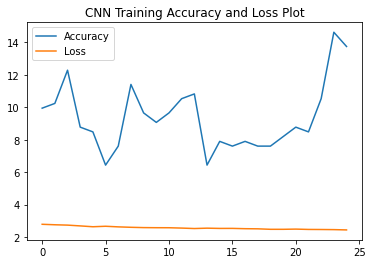

In [24]:
## Simple CNN Model

# Train and save the model
modelSimpleCNN,accuracy,loss = trainCNN(1,25,0.0001)
torch.save(modelSimpleCNN, 'modelSimpleCNN.pth')
plotCNNAccLoss(accuracy, loss)

In [25]:
print(modelSimpleCNN)
print(modelCNN)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (d1): Linear(in_features=131072, out_features=256, bias=True)
  (d2): Linear(in_features=256, out_features=15, bias=True)
  (sigmoid): Sigmoid()
)
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (d1): Linear(in_features=65536, out_features=256, bias=True)
  (d2): Linear(in_features=256, out_features=128, bias=True)
  (d3): Linear(in_features=128, out_features=15, bias=True)
  (sigmoid): Sigmoid()
)


In [26]:
# Predict single image
print(predictCNN("30.jpeg",modelCNN))
print(predictCNN("90.jpeg",modelCNN))

14
11


In [27]:
# CNN Model Test Accuracy
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = modelCNN(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('CNN Model Test Accuracy: %.2f'%( test_acc/i))

CNN Model Test Accuracy: 94.12


In [28]:
# CNN Model Total Accuracy
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(dataloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = modelCNN(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('CNN Model Total Accuracy: %.2f'%( test_acc/i))

CNN Model Total Accuracy: 92.98


In [29]:
# Simple CNN Model Test Accuracy
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = modelSimpleCNN(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Simple CNN Model Test Accuracy: %.2f'%( test_acc/i))

Simple CNN Model Test Accuracy: 13.73


In [30]:
# Simple CNN Model Total Accuracy
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(dataloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = modelSimpleCNN(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Simple CNN Model Total Accuracy: %.2f'%( test_acc/i))

Simple CNN Model Total Accuracy: 14.33


In [31]:
## VGG Feature Modle

modelVGG = trainVGG()
torch.save(modelVGG, 'modelVGG.pth')

Training Size: 240 Testing Size: 104
We are using device cpu


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG Model Total accuracy:  0.8546511627906976


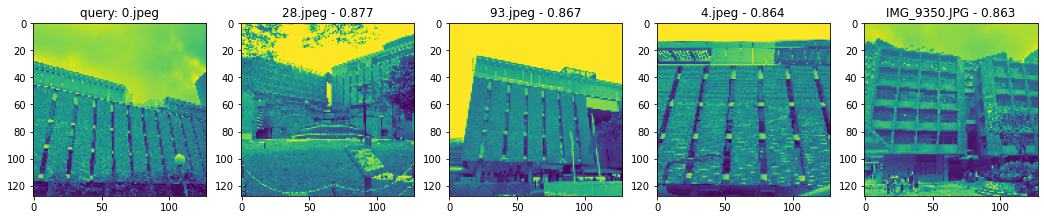

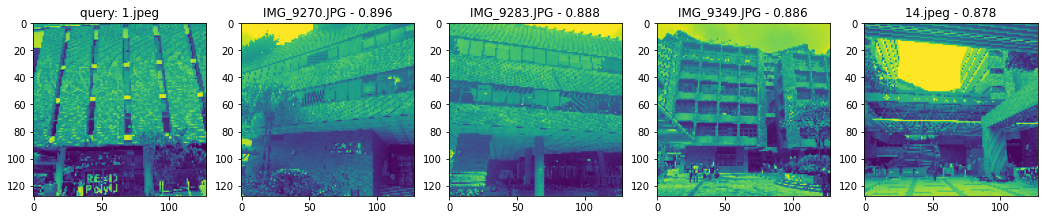

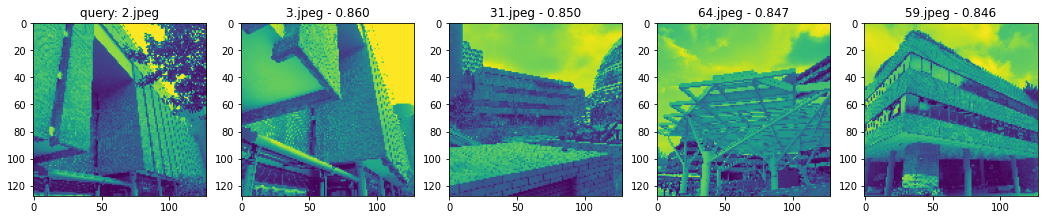

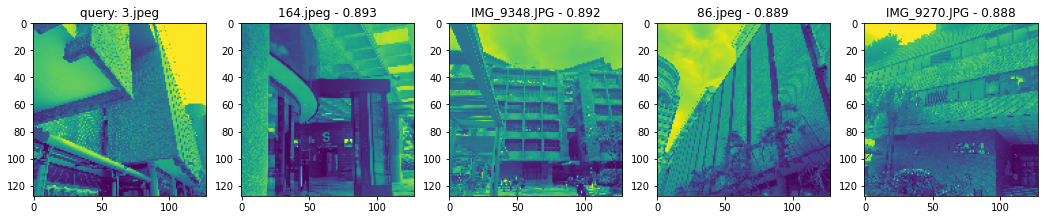

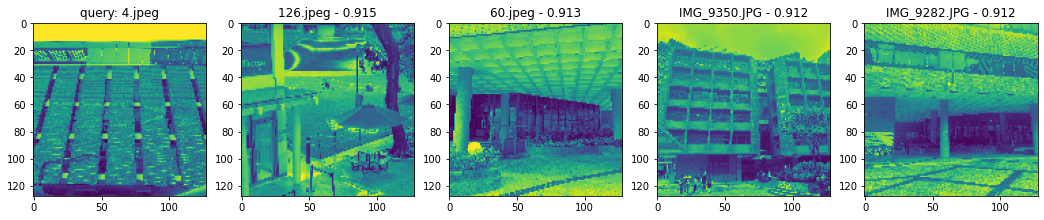

In [32]:
testVGG()

In [33]:
# Predict single image
print(predictVGG("27.jpeg",modelVGG))
print(predictVGG("90.jpeg",modelVGG))

14
11


Computing t-SNE embedding


<Figure size 1440x1440 with 0 Axes>

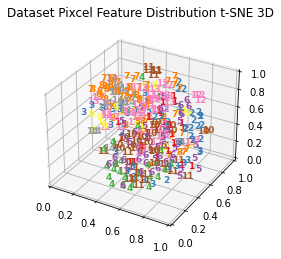

In [34]:
# check data pixcel feature 3D distribution with t-NSE
X = np.array([sample.feat for sample in samples])
y = [sample.label for sample in samples]

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_o = copy.deepcopy(X)
X_tsne = tsne.fit_transform(X)

def plot_embedding_3d(X, title=None):
    plt.figure(figsize=(20, 20))    
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]), color=plt.cm.Set1(y[i] / 15.), fontdict={'weight': 'bold', 'size': 9})
        if title is not None:
            plt.title(title)

plot_embedding_3d(X_tsne,"Dataset Pixcel Feature Distribution t-SNE 3D")

<ipython-input-35-eb8160221d6c>:12: UserWarning: 
The palette list has fewer values (4) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Pixcel Feature Distribution t-SNE 2D')


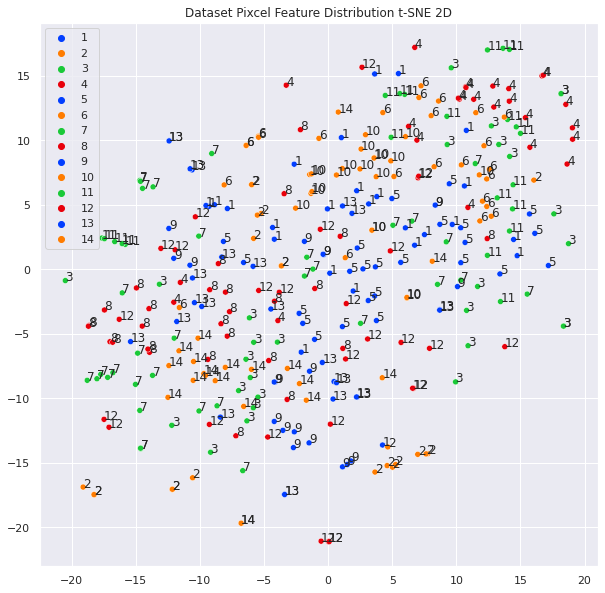

In [35]:
# check dataset pixcel feature 2D distribution with t-NSE

sns.set(rc={'figure.figsize':(10,10)}) 
palette = sns.color_palette("bright", 4) 

features = np.array([sample.feat for sample in samples])
labels = [sample.label for sample in samples]
ids = [(sample.label) for sample in samples]

tsne = TSNE() 
X_embedded = tsne.fit_transform(features)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Pixcel Feature Distribution t-SNE 2D')
for i, (x, y) in enumerate(X_embedded):
    plt.text(x, y, ids[i])

Computing t-SNE embedding


<Figure size 720x720 with 0 Axes>

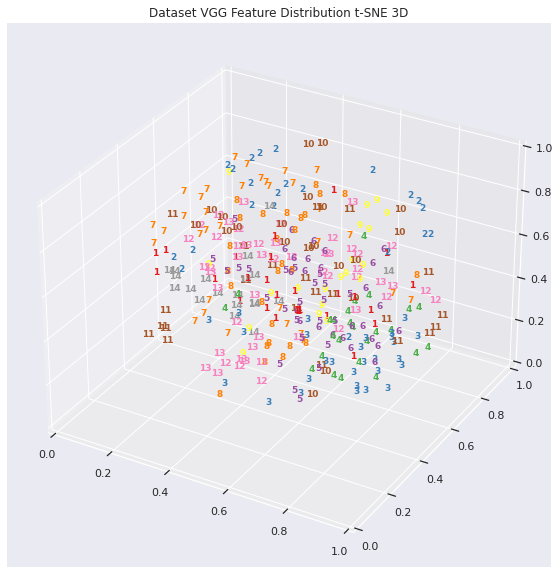

In [36]:
# check dataset VGG feature 3D distribution with t-NSE
X = np.array([np.array(sample.VGGfeat.cpu()[0]) for sample in samples])
y = [sample.label for sample in samples]

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_o = copy.deepcopy(X)
X_tsne = tsne.fit_transform(X)

def plot_embedding_3d(X, title=None):
    plt.figure(figsize=(10, 10))    
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]), color=plt.cm.Set1(y[i] / 15.), fontdict={'weight': 'bold', 'size': 9})
        if title is not None:
            plt.title(title)

plot_embedding_3d(X_tsne,"Dataset VGG Feature Distribution t-SNE 3D")

<ipython-input-37-2882e491ecd7>:12: UserWarning: 
The palette list has fewer values (4) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset VGG Feature Distribution t-SNE 2D')


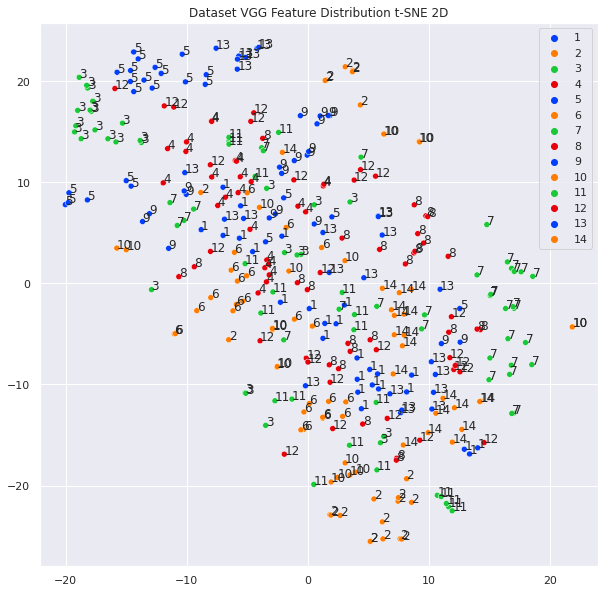

In [37]:
# check data VGG feature 2D distribution with t-NSE
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.color_palette("bright", 4)

features = np.array([np.array(sample.VGGfeat.cpu()[0]) for sample in samples])
labels = [sample.label for sample in samples]
ids = [(sample.label) for sample in samples]


tsne = TSNE() 
X_embedded = tsne.fit_transform(features) 
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset VGG Feature Distribution t-SNE 2D')
for i, (x, y) in enumerate(X_embedded):
    plt.text(x, y, ids[i])